In [43]:
###### load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

from scipy import stats # needed for ks test

from MAPseq_processing import * # import all functions from this script
from MAPseq_plotting import * # import all functions from this script

# needed for editable text in svg format
plt.rcParams['svg.fonttype'] = 'none'

# auto refreshes imported functions if source code changes:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# import metadata
from M194_M220_metadata import *

# import colormaps
from colormaps import blue_cmp, orange_cmp
# specify blue/orange colors for qualitative intervals/data
blue_qual = [blue_cmp.colors[50], blue_cmp.colors[100], blue_cmp.colors[150], blue_cmp.colors[200], blue_cmp.colors[250]]
orange_qual = [orange_cmp.colors[36], orange_cmp.colors[72], orange_cmp.colors[108], orange_cmp.colors[144], orange_cmp.colors[180], orange_cmp.colors[216], orange_cmp.colors[252]]


In [3]:
# load data
# set-up paths
home_dir = '/Volumes/Data/'
# home_dir = "/mnt/labNAS/"


in_path = home_dir+'Emily/MAPseq/combined_analysis_M194_M220/processed_data/'
# out_path = home_dir+'Emily/figures/fig_2_mapseq/figure_pics/'
out_path = "/Users/eisko/Documents/CSHL/mapseq_paper/svg_images/"

# Load normalized count data - minimum intervention
with open(in_path + 'M194_M220_OMC_separate_all_count.pkl', 'rb') as f:
    omc_count = pickle.load(f)
    
# with open(in_path + 'M194_M220_ACA_separate_all_count.pkl', 'rb') as f:
#     aca_count = pickle.load(f)

with open(in_path + 'M194_M220_OMC_separate_all_countN.pkl', 'rb') as f:
    omc_countN = pickle.load(f)
    
# with open(in_path + 'M194_M220_ACA_separate_all_countN.pkl', 'rb') as f:
#     aca_countN = pickle.load(f)

In [4]:
plot_areas = ['AOMCi', 'POMCi','AOMCc', 'POMCc', 'AUD', 'STRd',
       'STRv', 'TH', 'HY', 'HIP', 'AMY', 'SNr', 'SCm', 'PG', 'APAGd', 'APAGv',
       'PPAGd', 'PPAGv', 'RN']
omc_countN_cdf, foo = dfs_to_cdf(omc_countN, plot_areas=plot_areas)
omc_countN_cdf

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:681: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:711: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


NO BARCODES, cannot compute ECDF for HIP STF3
NO BARCODES, cannot compute ECDF for PPAGd STF3


,x,cdf,mice,species,dataset,area
0,0.000016,0.000000,MMM1,MMus,M194,AOMCi
1,0.000016,0.000000,MMM1,MMus,M194,AOMCi
2,0.000016,0.000000,MMM1,MMus,M194,AOMCi
3,0.000016,0.000000,MMM1,MMus,M194,AOMCi
4,0.000016,0.000000,MMM1,MMus,M194,AOMCi
...,...,...,...,...,...,...
995,4.756320,0.988235,STM7,STeg,M220,RN
996,4.805947,0.988235,STM7,STeg,M220,RN
997,4.856092,0.988235,STM7,STeg,M220,RN
998,4.906761,0.988235,STM7,STeg,M220,RN


# Normalize by median(s)

In [7]:
omc_countN[0].columns

Index(['OB', 'AOMCi', 'POMCi', 'ACAi', 'AOMCc', 'POMCc', 'ACAc', 'AUD', 'STRd',
       'STRv', 'TH', 'HY', 'AMY', 'HIP', 'SNr', 'SCm', 'PG', 'APAGd', 'APAGv',
       'PPAGd', 'PPAGv', 'RN', 'L1_ctl', 'H2O_inj_ctl', 'H2O_targ_ctl'],
      dtype='object')

In [9]:
# Calculate median BC to possibly use for batch correction (across all target regions)
targets = ['AOMCc', 'POMCc', 'ACAc', 'AUD', 'STRd',
       'STRv', 'TH', 'HY', 'AMY', 'HIP', 'SNr', 'SCm', 'PG', 'APAGd', 'APAGv',
       'PPAGd', 'PPAGv', 'RN']

medians = pd.DataFrame(columns=["AOMCi_med", "POMCi_med", "inj_med", "target_med", "all_med",
                                "mice", "species", "dataset"])


for i in range(metadata.shape[0]):
    df = omc_countN[i]

    # take nonzero median
#     aomci_df = df[df['inj_site']=="AOMCi"]
#     aomci = aomci_df["AOMCi"]
    aomci = df["AOMCi"]
    aomci = aomci[aomci!=0]
    aomci_med = aomci.median()

#     pomci_df = df[df['inj_site']=="POMCi"]
#     pomci = pomci_df["POMCi"]
    pomci = df["POMCi"]
    pomci = pomci[pomci!=0]
    pomci_med = pomci.median()

    # combine AOMCi and POMCi countN for inj_med
    inj_bc = pd.concat([aomci, pomci])
    inj_med = inj_bc.median()

    # calculate median from just nonzero countN in target sites
    target_bcN = pd.Series(dtype="float64")
    
    for area in targets:
       area_bc = df[area]
       area_bc = area_bc[area_bc!=0]
       target_bcN = pd.concat([target_bcN, area_bc])

    # calculate median of nonzero countN across whole brain
#     val_df = df.drop(["inj_site"], axis=1)
#     vals = val_df.values.flatten()
       vals = df.values.flatten()
    vals = vals[vals!=0]
    all_med = np.median(vals)
    
    target_med = target_bcN.median()

    row = [aomci_med, pomci_med, inj_med, target_med, all_med, 
           metadata.loc[i,"mice"], metadata.loc[i,"species"], metadata.loc[i,"dataset"]]

    medians.loc[i,:] = row

medians

,AOMCi_med,POMCi_med,inj_med,target_med,all_med,mice,species,dataset
0,0.000237,0.004716,0.002539,0.001943,0.002065,MMM1,MMus,M194
1,0.002419,0.001329,0.001851,0.001554,0.001568,MMF2,MMus,M194
2,0.000151,0.006886,0.003611,0.001858,0.00213,MMF3,MMus,M194
3,0.014109,0.000219,0.002657,0.002171,0.002253,STM1,STeg,M194
4,0.022241,0.000111,0.002291,0.002824,0.002676,STM2,STeg,M194
5,0.016985,0.000282,0.003292,0.00232,0.002359,STF3,STeg,M194
6,0.008931,0.032462,0.021942,0.052,0.042,MMM4,MMus,M220
7,0.00958,0.021571,0.015967,0.052189,0.037809,MMF5,MMus,M220
8,0.085362,0.04837,0.067535,0.05547,0.055879,STF4,STeg,M220
9,0.073774,0.010022,0.023501,0.108247,0.075486,STM5,STeg,M220


In [11]:
to_plot = ['OMCi', 'OMCc', 'AUD', 'STR', 'TH', 'HY', 'AMY', 'SNr', 
           'SCm', 'PG', 'PAG', 'RN']
to_drop = ['OB', 'ACAi', 'ACAc', 'HIP', 'L1_ctl', 'H2O_inj_ctl', 'H2O_targ_ctl']

# combine areas
omc_countN_comb = df_combine_areas(omc_countN, to_drop=to_drop)


# normalize by all barcodes median
omc_countN_med = []
for i in range(len(omc_countN_comb)):
    df = omc_countN_comb[i].copy()
    # df = df.drop(["inj_site"], axis=1)
    df_m = df/medians.loc[i, "all_med"]
    omc_countN_med.append(df_m)

# normalize by inj barcodes median
omc_countN_med_inj = []
for i in range(len(omc_countN_comb)):
    df = omc_countN_comb[i].copy()
    # df = df.drop(["inj_site"], axis=1)
    df_m = df/medians.loc[i, "inj_med"]
    omc_countN_med_inj.append(df_m)


/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:681: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:711: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


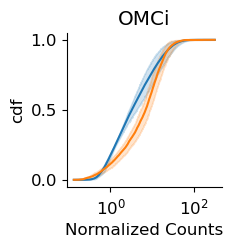

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:681: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:711: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


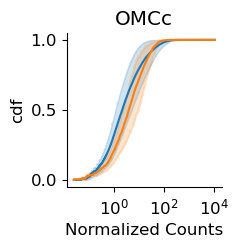

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:681: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:711: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


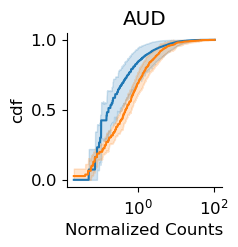

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:681: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:711: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


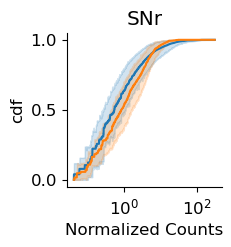

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:681: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_bc = pd.concat([all_bc, df])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:711: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cdf_df = pd.concat([cdf_df, int])


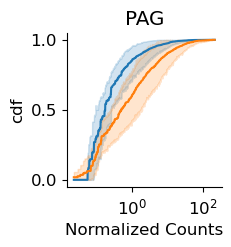

In [13]:
plot_ind = [["OMCi"], ["OMCc"], ["AUD"], ["SNr"], ["PAG"]]
labels = ["OMCi", "OMCc", "AUD", "SNr", "PAG"]

# NOTE: USED COUNTS NORMALIZED BY INJECTION SITE MEDIAN

# plot OMCi, OMCc, AUD, PAG, SNr seperately
for i in range(len(plot_ind)):
    area = plot_ind[i]
    plot_cdf(omc_countN_med_inj, plot_areas=area, color_by="species", title=None, legend=False, 
             individual=False, fig_size=(2,2))
    # plt.savefig(out_path+"cdf_comb_all_med_"+labels[i]+"_mean_ci95.svg", dpi=300, bbox_inches="tight")
    plt.show()


In [42]:
# CDF0.5 VALUES ARE NOT CORRECT, USING ECDF FUNCTION INCORRECTLY!!!
# areas = ["OMCc", "AUD", "SNr", "PAG"]

# # used normalized counts to inj median!
# cdf5_df = calc_cdf(omc_countN_med_inj, plot_areas=areas, cdf_val=0.5)

# for area in areas:
#     dot_plot(cdf5_df, area=area, title=area, to_plot="cdf_0.5")
#     # plt.savefig(out_path+"cdf5_"+area+"dotplot.svg", dpi=300, bbox_inches="tight")
#     plt.show()

In [51]:
# # calculate medians and make dot plot
# to_plot = ["OMCc", "AUD", "PAG", "SNr"]
# med_df = calc_medians(omc_countN_med_inj, plot_areas = to_plot)

# for area in to_plot:
#     dot_plot(med_df, area=area, title=area, to_plot="median")
#     plt.savefig(out_path+"median_"+area+"dotplot.svg", dpi=300, bbox_inches="tight")

#     plt.show()

In [52]:
# # confirm that cdf5 is the same as the median results
# test_df, test_ecdfs = dfs_to_cdf(omc_countN_med_inj, plot_areas=areas)
# test_ecdfs["STF6_PAG"](100)

,mice,species,sex,dataset,aud_med,pag_med
0,MMM1,MMus,male,M194,0.146976,0.074222
1,MMF2,MMus,female,M194,0.248756,0.167224
2,MMF3,MMus,female,M194,0.100319,0.110927
3,STM1,STeg,male,M194,0.434525,0.267119
4,STM2,STeg,male,M194,0.579923,0.505119
5,STF3,STeg,female,M194,0.262794,0.136998
6,MMM4,MMus,male,M220,0.747137,0.175290
7,MMF5,MMus,female,M220,0.106150,0.550469
8,STF4,STeg,female,M220,0.273455,0.131258
9,STM5,STeg,male,M220,0.511302,1.529151


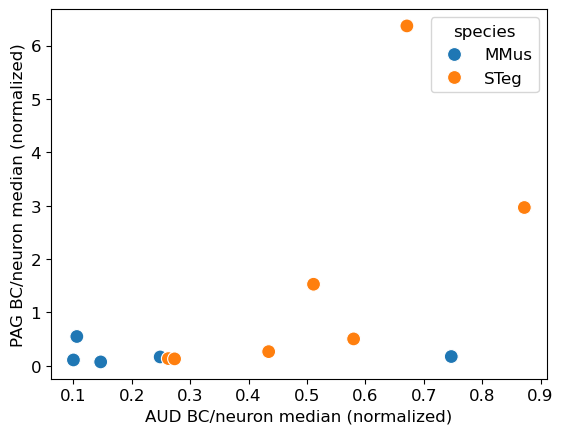

In [53]:
# calculate median
meds_aud_pag = metadata.copy()
aud_med = []
pag_med = []

for i in range(metadata.shape[0]):
    df = omc_countN_med_inj[i]
    # get area specific values
    # drop zeros

    aud_med = df['AUD'].replace(0,np.NaN).median()
    pag_med = df['PAG'].replace(0,np.NaN).median()
    meds_aud_pag.loc[i,'aud_med'] = aud_med
    meds_aud_pag.loc[i,'pag_med'] = pag_med

display(meds_aud_pag)

sns.scatterplot(meds_aud_pag, x="aud_med", y="pag_med", hue="species",
                s=100)
plt.xlabel("AUD BC/neuron median (normalized)")
plt.ylabel("PAG BC/neuron median (normalized)")
plt.savefig(out_path+"omc_norm_med_AUDvPAG.svg", dpi=300, bbox_inches="tight")

In [ ]:
# # scatter and volcano
# # normalize by all BC median


# # to_drop = ['OB', 'AOMCi', 'POMCi', 'ACAi', 'ACAc', 'HIP', 'L1_ctl', 'H2O_inj_ctl', 'H2O_targ_ctl']
# plot_med = dfs_to_medians(omc_countN_med, drop=[])
# stvmm_area_scatter(plot_med, to_plot="median", log=True, title="all_med normed, BC/Neuron", line_up_limit=10)
# plt.savefig(out_path+"scatter_comb_all_med.jpg", dpi=200, bbox_inches="tight")
# plt.show()


/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:762: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, df_add])
/Users/eisko/github_repos/MAPseq_analysis/MAPseq_plotting.py:432: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.pointplot(data=df, x="species", y=to_plot, hue="species", units='mice',


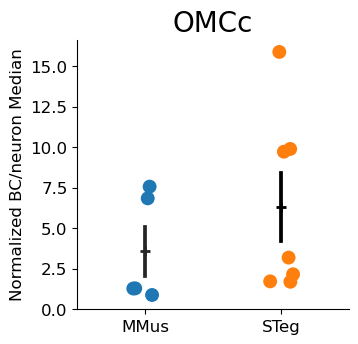

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_plotting.py:432: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.pointplot(data=df, x="species", y=to_plot, hue="species", units='mice',


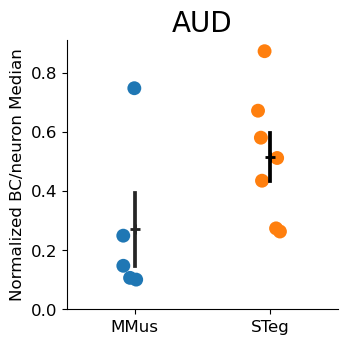

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_plotting.py:432: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.pointplot(data=df, x="species", y=to_plot, hue="species", units='mice',


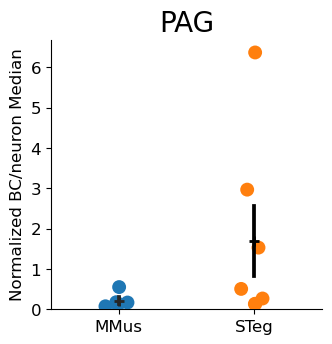

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_plotting.py:432: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.pointplot(data=df, x="species", y=to_plot, hue="species", units='mice',


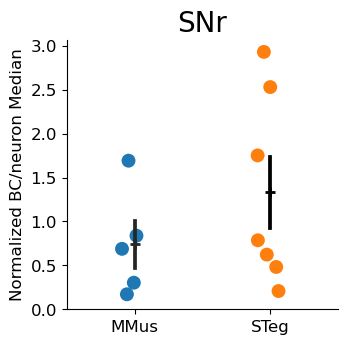

In [63]:
plot_med = dfs_to_medians(omc_countN_med_inj, drop=[])
for area in to_plot:
    dot_plot(plot_med, area=area, title=area, to_plot="median")
    plt.ylabel("Normalized BC/neuron Median")
    plt.savefig(out_path+"median_"+area+"dotplot.svg", dpi=300, bbox_inches="tight")

    plt.show()

/Users/eisko/github_repos/MAPseq_analysis/MAPseq_processing.py:762: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_df = pd.concat([plot_df, df_add])


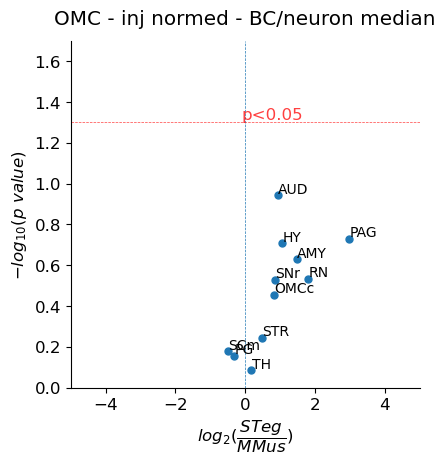

In [62]:

# volcano
plot_med = dfs_to_medians(omc_countN_med_inj, drop=["OMCi"])
plot = proportion_ttest(plot_med, to_plot="median")
plot_volcano(plot, p_01=False, title="OMC - inj normed - BC/neuron median", xlim=(-5,5), legend_loc=None,
             fig_size=(4.5,4.5))

plt.savefig(out_path+"volcano_comb_inj_med.svg", dpi=300, bbox_inches="tight")
plt.show()

# scatter and volcano
- can only compare 2 samples at a time w/ KS
- decided to look at median per area so can compare across groups

## w/in dataset

In [ ]:
m194 = []
m220 = []
for i in range(metadata.shape[0]):
    if metadata.loc[i,"dataset"]=="M194":
        m194.append(omc_countN[i])
    elif metadata.loc[i,"dataset"]=="M220":
        m220.append(omc_countN[i])

### M194

In [ ]:
plot_med = dfs_to_medians(m194)
stvmm_area_scatter(plot_med, to_plot="median", log=True, title="M194, No normalization, BC/Neuron", 
                   ax_limits=(0.0001, 1))
plt.show()

# volcano
plot = proportion_ttest(plot_med, to_plot="median")
plot_volcano(plot, title="M194, no normalization, BC/neuron median", xlim=(-5,5))
plt.show()

### M220

In [ ]:
plot_med = dfs_to_medians(m220)
stvmm_area_scatter(plot_med, to_plot="median", log=True, title="M220, No normalization, BC/Neuron",
                   ax_limits=(0.0001, 1))
plt.show()

# volcano
plot = proportion_ttest(plot_med, to_plot="median")
plot_volcano(plot, title="M220, no normalization, BC/neuron median", xlim=(-5,5))
plt.show()